# Usage of taxi services

In [1]:
import os
import logging
import json
import calendar

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from datetime import datetime, time

In [261]:
# Variables

DATE_FORMAT = "%m%d%Y"
RAW_PATH = "../src/data/raw_file/"
LANDING_PATH = "../src/data/landing/"
DATE_NOW = datetime.now()

TAXI_FILE_PATH = f"../src/data/raw_file/{DATE_NOW.strftime(DATE_FORMAT)}_taxi.json"

1. File extraction definition and othe utils functions

In [6]:
class FileExtraction:
    def __init__(self, landing_path, raw_path, date):
        self._landing_path = landing_path
        self._raw_path = raw_path
        self._date = date.strftime(DATE_FORMAT)

    @property
    def date(self):
        return self._date
    
    @date.setter
    def date(self, new_date):
        self._date = new_date.strftime(DATE_FORMAT)

    @property
    def landing_path(self):
        return self._landing_path

    @landing_path.setter
    def landing_path(self, path):
        self._landing_path = self.validate_directory(path)

    @property
    def raw_path(self):
        return self._raw_path

    @raw_path.setter
    def raw_path(self, path):
        self._raw_path = self.validate_directory(path)

    @staticmethod
    def validate_directory(path):
        if os.path.isdir(path):
            return path
        else:
            logging.error("Please use a valid file path.")

    def load_compressed_file(self):
        files = [file for file in os.listdir(self._landing_path)
                 if os.path.isfile(os.path.join(self._landing_path, file))]

        for file in files:
            with ZipFile(os.path.join(self._landing_path, file)) as zip_file:
                for zip_ in zip_file.namelist():
                    origin_name = f"{self._raw_path}{zip_}"
                    destine_name = f"{self._raw_path}{self._date}_{zip_}"

                    if zip_.endswith('.json') and "__MACOSX" not in zip_:
                        zip_file.extract(zip_, self._raw_path)
                        os.replace(origin_name, destine_name)

In [7]:
def read_json_data(path):
    with open(path, 'r') as file:
        return json.loads(file.read())

2. Invokes FileExtraction class and extracts the zip file

In [15]:
fileExtraction = FileExtraction(raw_path=RAW_PATH, landing_path=LANDING_PATH, date=DATE_NOW)

fileExtraction.load_compressed_file()

3. Reads the json from extracted zip file

In [84]:
taxi_data = read_json_data(TAXI_FILE_PATH)

4. Loads into dataframe

In [85]:
df_taxi = pd.json_normalize(taxi_data)

5. Check data information

In [86]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23867 entries, 0 to 23866
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   amount.value                23867 non-null  int64  
 1   amount.precision            23867 non-null  int64  
 2   amount.currency             23867 non-null  object 
 3   transaction_info.number     12019 non-null  float64
 4   transaction_info.machine    0 non-null      object 
 5   transaction_info.timestamp  12019 non-null  float64
 6   transaction_info.country    10352 non-null  object 
 7   transaction_info.currency   10352 non-null  object 
 8   transaction_info.partner    0 non-null      object 
dtypes: float64(2), int64(2), object(5)
memory usage: 1.6+ MB


In [87]:
df_taxi.head()

,amount.value,amount.precision,amount.currency,transaction_info.number,transaction_info.machine,transaction_info.timestamp,transaction_info.country,transaction_info.currency,transaction_info.partner
0,-279000,5,EUR,NaN,None,NaN,None,None,None
1,-1000000,5,EUR,NaN,None,NaN,None,None,None
2,-945000,5,EUR,NaN,None,NaN,None,None,None
3,-1100000,5,EUR,1.0,None,1.621374e+12,AT,EUR,None
4,-556000,5,EUR,NaN,None,NaN,None,None,None


In [88]:
# check the number of records before processing
df_before = df_taxi.shape

print(f"Dataframe shape before processing: {df_before}")

Dataframe shape before processing: (23867, 9)


## Data transform process

1. Rename the columns - Replace "." to "-": It is better to work with columns names without dots. Prevents errors on data columns invocation

In [89]:
df_taxi.columns = df_taxi.columns.str.replace('.', '_', regex = True)

In [90]:
# Check the results
df_taxi.columns

Index(['amount_value', 'amount_precision', 'amount_currency',
       'transaction_info_number', 'transaction_info_machine',
       'transaction_info_timestamp', 'transaction_info_country',
       'transaction_info_currency', 'transaction_info_partner'],
      dtype='object')

2. Check number of NaN values and replace it

In [91]:
df_taxi.isna().sum()

amount_value                      0
amount_precision                  0
amount_currency                   0
transaction_info_number       11848
transaction_info_machine      23867
transaction_info_timestamp    11848
transaction_info_country      13515
transaction_info_currency     13515
transaction_info_partner      23867
dtype: int64

### Replacing NaN values

- As described, the money amount has the precision set to 5 digits. For the exploratory analysis, the script will replace all NaN to 0 in columns with number type and replace NaN to "" to columns with string type. 

Checks if excists any 0 in the dataset as a representative information

In [92]:
df_taxi.isin([0]).sum()

amount_value                  0
amount_precision              0
amount_currency               0
transaction_info_number       0
transaction_info_machine      0
transaction_info_timestamp    0
transaction_info_country      0
transaction_info_currency     0
transaction_info_partner      0
dtype: int64

- In pandas dataframes, string has type "object" and numbers usually have "float64"type. As described in dataframe information at, we have

In [93]:
float64 = df_taxi.select_dtypes(include=['float64']).columns
stringObject = df_taxi.select_dtypes(include=['object']).columns

In [94]:
# filling the NaN values
df_taxi.loc[:, float64] = df_taxi.loc[:, float64].apply(lambda value: value.fillna(0))
df_taxi.loc[:, stringObject] = df_taxi.loc[:, stringObject].apply(lambda value: value.fillna(""))

In [95]:
df_taxi.head()

,amount_value,amount_precision,amount_currency,transaction_info_number,transaction_info_machine,transaction_info_timestamp,transaction_info_country,transaction_info_currency,transaction_info_partner
0,-279000,5,EUR,0.0,,0.000000e+00,,,
1,-1000000,5,EUR,0.0,,0.000000e+00,,,
2,-945000,5,EUR,0.0,,0.000000e+00,,,
3,-1100000,5,EUR,1.0,,1.621374e+12,AT,EUR,
4,-556000,5,EUR,0.0,,0.000000e+00,,,


3. Converting date type to datetime

In [96]:
df_taxi["transaction_info_timestamp"] =  df_taxi["transaction_info_timestamp"].apply(lambda value: 
                                                                                     pd.to_datetime(value, unit='ms', errors='coerce')
                                                                                    if value != 0 else None)

In [97]:
df_taxi.head()

,amount_value,amount_precision,amount_currency,transaction_info_number,transaction_info_machine,transaction_info_timestamp,transaction_info_country,transaction_info_currency,transaction_info_partner
0,-279000,5,EUR,0.0,,NaT,,,
1,-1000000,5,EUR,0.0,,NaT,,,
2,-945000,5,EUR,0.0,,NaT,,,
3,-1100000,5,EUR,1.0,,2021-05-18 21:34:00,AT,EUR,
4,-556000,5,EUR,0.0,,NaT,,,


For the analysis, the transaction_info_timestamp is an important information to describe the data. Thus, we will remove all lines that have NaN/NaT/None type in this column.

In [98]:
df_taxi.dropna(inplace= True)

In [99]:
df_taxi.head()

,amount_value,amount_precision,amount_currency,transaction_info_number,transaction_info_machine,transaction_info_timestamp,transaction_info_country,transaction_info_currency,transaction_info_partner
3,-1100000,5,EUR,1.0,,2021-05-18 21:34:00,AT,EUR,
5,-910000,5,EUR,3.0,,2021-05-18 15:36:00,AT,EUR,
6,-1400000,5,EUR,2.0,,2021-05-18 05:55:00,AT,EUR,
9,-1900000,5,EUR,3.0,,2021-05-18 04:49:00,AT,EUR,
10,-2200000,5,EUR,1.0,,2021-05-18 05:22:00,AT,EUR,


4. As described 

    Money amounts are expressed using two integers: value and in addition
    precision which defines how many last digits of value represent currency subunit.
    For instance, for currency CHF, value of 5506000 with precision of 5 means the
    amount was 55 francs and 6 centimes (i.e. 55.06 CHF).
    
For achive this format, the amount_value column will be convert to float and it will be moved the float point to the precision described in amount_precision column.

In [100]:
df_taxi["amount_value"] = df_taxi["amount_value"].apply(lambda amount: float(amount))

In [101]:
df_taxi["amount_value"] = df_taxi["amount_value"]*np.float_power(10, -df_taxi["amount_precision"])

Checking the data after the processing amount

In [102]:
df_taxi.head()

,amount_value,amount_precision,amount_currency,transaction_info_number,transaction_info_machine,transaction_info_timestamp,transaction_info_country,transaction_info_currency,transaction_info_partner
3,-11.0,5,EUR,1.0,,2021-05-18 21:34:00,AT,EUR,
5,-9.1,5,EUR,3.0,,2021-05-18 15:36:00,AT,EUR,
6,-14.0,5,EUR,2.0,,2021-05-18 05:55:00,AT,EUR,
9,-19.0,5,EUR,3.0,,2021-05-18 04:49:00,AT,EUR,
10,-22.0,5,EUR,1.0,,2021-05-18 05:22:00,AT,EUR,


5. Adds a new columns named "day_of_the_week". It will identifies the day of the week in "transaction_info_timestamp"

In [103]:
df_taxi["day_of_the_week"] = df_taxi["transaction_info_timestamp"].apply(lambda date: calendar.day_name[date.weekday()])

In [104]:
df_taxi.head()

,amount_value,amount_precision,amount_currency,transaction_info_number,transaction_info_machine,transaction_info_timestamp,transaction_info_country,transaction_info_currency,transaction_info_partner,day_of_the_week
3,-11.0,5,EUR,1.0,,2021-05-18 21:34:00,AT,EUR,,Tuesday
5,-9.1,5,EUR,3.0,,2021-05-18 15:36:00,AT,EUR,,Tuesday
6,-14.0,5,EUR,2.0,,2021-05-18 05:55:00,AT,EUR,,Tuesday
9,-19.0,5,EUR,3.0,,2021-05-18 04:49:00,AT,EUR,,Tuesday
10,-22.0,5,EUR,1.0,,2021-05-18 05:22:00,AT,EUR,,Tuesday


In [105]:
df_after = df_taxi.shape
diff = (df_before[0] - df_after[0])

print(f"Dataframe shape after processing: {df_after}")
print(f"Information after processing: {diff} rows")

Dataframe shape after processing: (12019, 10)
Information after processing: 11848 rows


For better analysis, we will check if "amount_value" have any positive value. Thus, if false, it will convert all values to positive ones. This is will help to visualize the future plots.

- Checks for any positive values in "amount_value"

In [106]:
(df_taxi["amount_value"] > 0).values.any()

False

In [107]:
df_taxi["amount_value"] = df_taxi["amount_value"]*(-1)

In [108]:
df_taxi.head()

,amount_value,amount_precision,amount_currency,transaction_info_number,transaction_info_machine,transaction_info_timestamp,transaction_info_country,transaction_info_currency,transaction_info_partner,day_of_the_week
3,11.0,5,EUR,1.0,,2021-05-18 21:34:00,AT,EUR,,Tuesday
5,9.1,5,EUR,3.0,,2021-05-18 15:36:00,AT,EUR,,Tuesday
6,14.0,5,EUR,2.0,,2021-05-18 05:55:00,AT,EUR,,Tuesday
9,19.0,5,EUR,3.0,,2021-05-18 04:49:00,AT,EUR,,Tuesday
10,22.0,5,EUR,1.0,,2021-05-18 05:22:00,AT,EUR,,Tuesday


Checks the date period for the dataset after processing:

In [127]:
min_dt = min(df_taxi.transaction_info_timestamp)
max_dt = max(df_taxi.transaction_info_timestamp)

print(f"Date init: {min_dt}\nDate ends: {max_dt}")

Date init: 2021-05-17 22:03:00
Date ends: 2021-05-31 21:55:00


As we have information for a half month, let's agreggate then:

To check when are the taxi services most called, We will group the data by day_of_the_week and transaction hour

In [128]:
amount_per_hour_per_day = df_taxi.groupby([df_taxi['transaction_info_timestamp'].dt.hour,
                                          df_taxi['day_of_the_week']]
                                         )['amount_value'].sum().unstack(fill_value=0)

In [129]:
amount_per_hour_per_day.head()

day_of_the_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
transaction_info_timestamp,,,,,,,
0,586.80,672.36,3424.87,3021.07,541.30,391.30,208.40
1,563.71,642.89,2237.64,2137.07,485.28,272.90,263.55
2,394.98,282.50,1398.27,1538.70,293.20,243.69,181.80
3,746.69,390.90,811.40,702.86,859.40,436.60,509.00
4,975.91,810.70,633.70,734.84,742.33,809.00,873.12


For better identificatrion, let's change the multi index names

In [130]:
amount_per_hour_per_day.index.names = ['Hour']

In [131]:
amount_per_hour_per_day.columns.names = ["Index"]

In [132]:
amount_per_hour_per_day.head()

Index,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Hour,,,,,,,
0,586.80,672.36,3424.87,3021.07,541.30,391.30,208.40
1,563.71,642.89,2237.64,2137.07,485.28,272.90,263.55
2,394.98,282.50,1398.27,1538.70,293.20,243.69,181.80
3,746.69,390.90,811.40,702.86,859.40,436.60,509.00
4,975.91,810.70,633.70,734.84,742.33,809.00,873.12


For this case, the expression <i>df_taxi['transaction_info_timestamp'].dt.hour</i> will consider the hour of the transaction. Thus, our analysis will user "amount per hour per day" agreggation. 

Tip: the index is the same as the hour column information. Them, reseting the index, we will have the column hour

In [133]:
amount_per_hour_per_day.reset_index(level = ["Hour"], inplace = True)

In [134]:
amount_per_hour_per_day.head()

Index,Hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,586.80,672.36,3424.87,3021.07,541.30,391.30,208.40
1,1,563.71,642.89,2237.64,2137.07,485.28,272.90,263.55
2,2,394.98,282.50,1398.27,1538.70,293.20,243.69,181.80
3,3,746.69,390.90,811.40,702.86,859.40,436.60,509.00
4,4,975.91,810.70,633.70,734.84,742.33,809.00,873.12


Converts the int identification for the hour to time format. We will use it as a dimention information type for future analysis.

In [135]:
fat_hour = pd.DataFrame(amount_per_hour_per_day["Hour"].apply(lambda hour: time(hour).strftime("%I:00 %p")))

In [136]:
fat_hour.head()

,Hour
0,12:00 AM
1,01:00 AM
2,02:00 AM
3,03:00 AM
4,04:00 AM


With this new dataframe, we will drop the Hour column from the fat dataframe amount_per_hour_per_day

In [137]:
amount_per_hour_per_day.drop("Hour", axis = 1, inplace = True)

In [138]:
amount_per_hour_per_day.head()

Index,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,586.80,672.36,3424.87,3021.07,541.30,391.30,208.40
1,563.71,642.89,2237.64,2137.07,485.28,272.90,263.55
2,394.98,282.50,1398.27,1538.70,293.20,243.69,181.80
3,746.69,390.90,811.40,702.86,859.40,436.60,509.00
4,975.91,810.70,633.70,734.84,742.33,809.00,873.12


Ordering the days of the week, we have

In [139]:
amount_per_hour_per_day = amount_per_hour_per_day[["Monday","Tuesday","Wednesday","Thursday", "Friday", "Saturday", "Sunday"]]

In [140]:
amount_per_hour_per_day.head()

Index,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,672.36,391.30,208.40,541.30,586.80,3424.87,3021.07
1,642.89,272.90,263.55,485.28,563.71,2237.64,2137.07
2,282.50,243.69,181.80,293.20,394.98,1398.27,1538.70
3,390.90,436.60,509.00,859.40,746.69,811.40,702.86
4,810.70,809.00,873.12,742.33,975.91,633.70,734.84


## Exploratory analysis

1. When are taxi services used most often? what can explain usage patterns?
- To check this information, let's plot the consolidate data

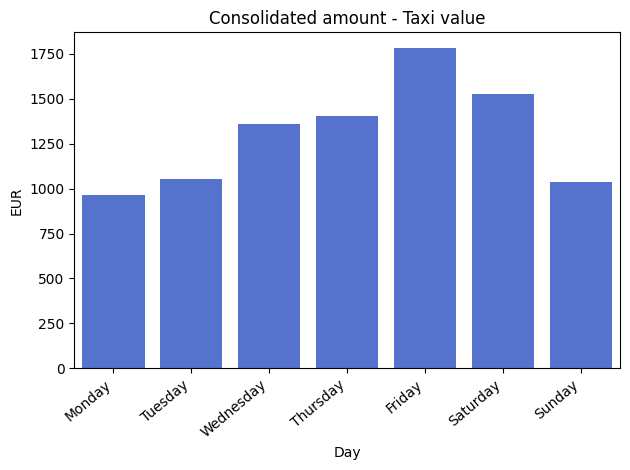

In [142]:
daily_plot = sns.barplot(amount_per_hour_per_day, errorbar = None, color = "royalblue")

daily_plot.set_title("Consolidated amount - Taxi value")
daily_plot.set_xlabel("Day")
daily_plot.set_ylabel("EUR")

daily_plot.set_xticklabels(daily_plot.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

As observed, Friday and Saturday are the days that taxi is used most often. We can consider that, in the weekend, people take more taxi to hanging out at night when the prices could be higher.

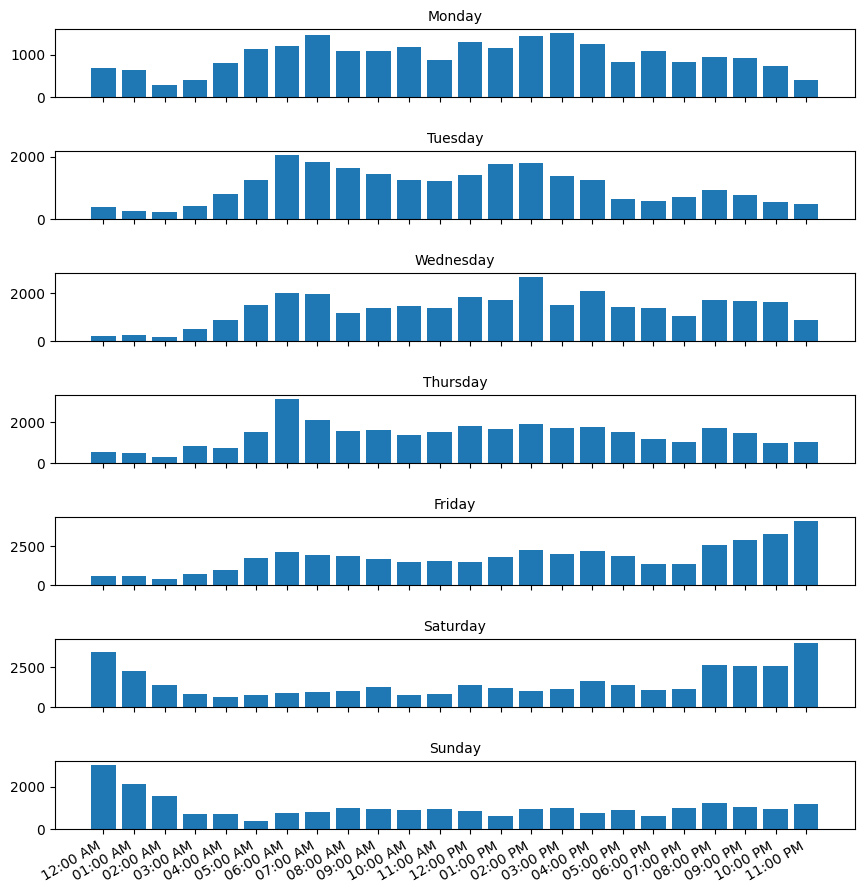

In [193]:
figure, axis = plt.subplots(7, 1, figsize=(10, 8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.2,
                    wspace=0.8,
                    hspace=0.8)
for index, day in enumerate(amount_per_hour_per_day):
    axis[index].bar(fat_hour.Hour, amount_per_hour_per_day[day])
    axis[index].set_title(f"{day}", fontsize=10)

figure.autofmt_xdate()

With the data plot per dat, we can observe that during Monday to Thursday, we have the amount spent on taxi along the day (6AM - 5PM). On Friday and Saturday, the taxi usage increases at 8PM to midnight for the next day.

2. What is the typical amount of money spent on taxi service?

Let's check the spent amount by hour. For this, we will analyse the median and the mean of amount value. The next plots will consider by day for the calculus. 

In [215]:
amount_per_day_mean = df_taxi.groupby([df_taxi['day_of_the_week']]
               )['amount_value'].mean()

In [250]:
amount_per_day_median = df_taxi.groupby([df_taxi['day_of_the_week']]
               )['amount_value'].median()

In [259]:
amount_per_day_mean

day_of_the_week
Friday       18.025540
Monday       18.952949
Saturday     17.711490
Sunday       18.324529
Thursday     18.729316
Tuesday      18.059264
Wednesday    18.113902
Name: amount_value, dtype: float64

In [260]:
amount_per_day_median

day_of_the_week
Friday       16.0
Monday       16.0
Saturday     15.0
Sunday       15.8
Thursday     15.8
Tuesday      16.0
Wednesday    15.0
Name: amount_value, dtype: float64

As observed in the results, the amount spent is constant if considered the absolute value. We have both results, mean and median, to observe the deviation resulted by outliers in the mean calculation.

## Conclusions and comments

Finally, based on the results before, we can get the following conclusions:

- The taxi usage depends on the day of the week and the hour. Thus, the total amount spend will be greater on weekends and on working days.
- On consolidated data, we observed that the amount spent is bigger on Friday and on Saturday.
- Oberserving the Amount per Hour per Day, we can observe that on the weekends, the amound spent is greater at night. During the working day, we have the meaian around 8AM-4PM. 